<a href="https://colab.research.google.com/github/seattlelizzard/CrashSeattle/blob/main/lizzmergecode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Common import header (stolen from Sensys Data.ipynb from this dir)

In [1]:
!pip install geopandas
!pip install swifter
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import swifter
# seaborn is a data visualization library built on matplotlib
import seaborn as sns 

# set the plotting style 
sns.set_style("whitegrid")
import geopandas as gpd
from shapely.geometry import Point, Polygon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 5.6 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 7.2 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 kB 6.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Preparing metadata (setup.py) ... done


  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16321 sha256=637c2a1071b1383de511fa7d6bc55174783ae0b8c0b8a93e99372932edab52d7
  Stored in directory: /home/lizz/.cache/pip/wheels/40/ac/82/e6e08c451973c2764ee709b175a5b899866119bccf5206a65d
Successfully built swifter

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#cd drive/MyDrive/

In [2]:
sensloc = pd.read_csv('Sensys_location.csv')

In [3]:
sensloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16808676 entries, 0 to 16808675
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Unnamed: 0   int64  
 1   Time         object 
 2   APEG         object 
 3   Sensor Zone  object 
 4   Occup (%)    float64
 5   Vol          float64
 6   year         int64  
 7   Name         object 
 8   Latitude     float64
 9   Longitude    float64
dtypes: float64(4), int64(2), object(4)
memory usage: 1.3+ GB


In [4]:
sensloc.head()

,Unnamed: 0,Time,APEG,Sensor Zone,Occup (%),Vol,year,Name,Latitude,Longitude
0,0,09/01/2021 14:00:00 PDT,apeg0125,0125S_NBT_1,16.04,115.0,2021,Ballard Bridge,47.658978,-122.376148
1,1,09/01/2021 14:05:00 PDT,apeg0125,0125S_NBT_1,9.53,74.0,2021,Ballard Bridge,47.658978,-122.376148
2,2,09/01/2021 14:10:00 PDT,apeg0125,0125S_NBT_1,7.70,66.0,2021,Ballard Bridge,47.658978,-122.376148
3,3,09/01/2021 14:15:00 PDT,apeg0125,0125S_NBT_1,4.89,47.0,2021,Ballard Bridge,47.658978,-122.376148
4,4,09/01/2021 14:20:00 PDT,apeg0125,0125S_NBT_1,6.54,56.0,2021,Ballard Bridge,47.658978,-122.376148


In [5]:
crashdf = pd.read_csv('collisions.csv')

In [6]:
crashdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237176 entries, 0 to 237175
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                229433 non-null  float64
 1   Y                229433 non-null  float64
 2   OBJECTID         237176 non-null  int64  
 3   INCKEY           237176 non-null  int64  
 4   COLDETKEY        237176 non-null  int64  
 5   ADDRTYPE         233311 non-null  object 
 6   COLLISIONTYPE    205840 non-null  object 
 7   EXCEPTRSNCODE    116773 non-null  object 
 8   EXCEPTRSNDESC    12436 non-null   object 
 9   FATALITIES       237176 non-null  int64  
 10  INATTENTIONIND   30613 non-null   object 
 11  INCDATE          237176 non-null  object 
 12  INCDTTM          237176 non-null  object 
 13  INJURIES         237176 non-null  int64  
 14  INTKEY           78120 non-null   float64
 15  JUNCTIONTYPE     224616 non-null  object 
 16  LIGHTCOND        205519 non-null  obje

In [7]:
uniques = crashdf.nunique()
uniques[uniques < 100]

ADDRTYPE            3
COLLISIONTYPE      10
EXCEPTRSNCODE       2
EXCEPTRSNDESC       1
FATALITIES          6
INATTENTIONIND      1
INJURIES           16
JUNCTIONTYPE        7
LIGHTCOND           9
PEDCOUNT            7
PEDCYLCOUNT         4
PEDROWNOTGRNT       1
PERSONCOUNT        49
ROADCOND            9
SDOT_COLCODE       41
SDOT_COLDESC       41
SERIOUSINJURIES     7
SEVERITYCODE        5
SEVERITYDESC        5
SPEEDING            1
ST_COLCODE         64
ST_COLDESC         63
STATUS              2
UNDERINFL           4
VEHCOUNT           16
WEATHER            12
HITPARKEDCAR        2
dtype: int64

In [8]:
crashdf['WEATHER'] = crashdf['WEATHER'].replace('Unknown', np.nan)

In [9]:
sensorlocations = sensloc[['Name', 'Latitude', 'Longitude']].groupby(by = 'Name').max()

In [10]:
sensorlocations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 1st & Edgar Martinez to Westlake Ave N & Mercer St
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   38 non-null     float64
 1   Longitude  38 non-null     float64
dtypes: float64(2)
memory usage: 912.0+ bytes


Neat okay the labels for xy coordinates for each sensor are consistent. 

What we want is our crash dataset to have a column for the nearest sensor (NAME), as well as the sensor readings at the time closest to the crash. 

We will do this first by adding a column to the crash database for the nearest sensor, and a column for it's distance from that sensor so we can perhaps prune our crash dataset for only crashes sufficiently close to a sensor.

In [11]:
#Implimenting https://en.wikipedia.org/wiki/Haversine_formula for distance on sphere
def havsin(theta): #Haversine function
  return np.sin(theta/2)**2

def archavsin(y):
  return 2*np.arcsin(np.sqrt(y))


def distance(lat1, lon1, lat2, lon2): 
  r =  3958.8 #miles
  #r = 6378.1 #kilometers
  pphi = (lat2 + lat1)*np.pi/180.
  dphi = (lat2 - lat1)*np.pi/180.
  dlambda = (lon2 - lon1)*np.pi/180.
  havtheta = havsin(dphi) + (1-havsin(dphi) -havsin(pphi))*havsin(dlambda)
  theta = archavsin(havtheta)
  dist = r*theta
  return dist




I don't feel bad looping over our tiny dataframe of locations to add columns to our crash dataset. 

In [12]:
for sensor in sensorlocations.index.values:
  crashdf[sensor] = distance(sensorlocations.loc[sensor]['Latitude'],sensorlocations.loc[sensor]['Longitude'], crashdf['Y'], crashdf['X'])
  #print(sensorlocations.loc[sensor]['Latitude'])

In [13]:
crashdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237176 entries, 0 to 237175
Data columns (total 78 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   X                                             229433 non-null  float64
 1   Y                                             229433 non-null  float64
 2   OBJECTID                                      237176 non-null  int64  
 3   INCKEY                                        237176 non-null  int64  
 4   COLDETKEY                                     237176 non-null  int64  
 5   ADDRTYPE                                      233311 non-null  object 
 6   COLLISIONTYPE                                 205840 non-null  object 
 7   EXCEPTRSNCODE                                 116773 non-null  object 
 8   EXCEPTRSNDESC                                 12436 non-null   object 
 9   FATALITIES                                    23

In [14]:
crashdf['Nearest Sensor'] = crashdf.loc[:,'1st & Edgar Martinez':'Westlake Ave N & Mercer St'].idxmin(axis = 1)

In [15]:
crashdf['Distance'] = crashdf.loc[:,'1st & Edgar Martinez':'Westlake Ave N & Mercer St'].min(axis = 1)

In [16]:
crashdf.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,ADDRTYPE,COLLISIONTYPE,EXCEPTRSNCODE,EXCEPTRSNDESC,FATALITIES,...,Highland Park Way SW at West Marginal Way SW,S Michigan St at 4th Ave S,SW Roxbury St at 15th Ave SW,South Park Bridge,Spokane St Low Bridge,Spokane St Viaduct,West Marginal Way SW at Duwamish River Trail,Westlake Ave N & Mercer St,Nearest Sensor,Distance
0,-122.264594,47.523882,1,63300,63300,Block,Parked Car,NaN,NaN,0,...,3.799783,3.376121,4.168607,2.347772,5.131289,4.630209,4.956394,7.752668,South Park Bridge,2.347772
1,-122.313029,47.670213,2,1194,1194,Block,Parked Car,,NaN,0,...,9.077666,8.661221,10.725932,9.611046,7.032076,6.882649,7.563970,3.372456,Aurora Bridge,2.271339
2,-122.270060,47.510992,3,46900,46900,Block,Parked Car,NaN,NaN,0,...,3.933720,3.654484,3.914819,2.468082,5.570359,5.149779,5.317653,8.461315,South Park Bridge,2.468082
3,-122.312719,47.655347,4,58300,58300,Block,Angles,NaN,NaN,0,...,8.066153,7.640191,9.719241,8.583971,6.043868,5.870471,6.576764,2.443359,Aurora Bridge,1.713593
4,-122.339439,47.565776,5,120500,120500,Intersection,Right Turn,NaN,NaN,0,...,1.763679,1.483458,3.406548,2.677658,0.596617,0.471394,0.627137,4.055615,1st Ave S & S Spokane St,0.449235


In [17]:
crashdf = crashdf.drop(crashdf.loc[:,'1st & Edgar Martinez':'Westlake Ave N & Mercer St'], axis = 1)

<AxesSubplot:>

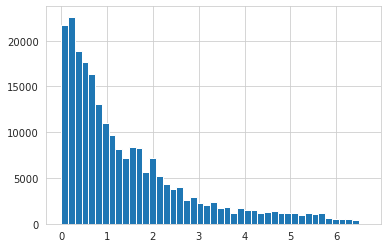

In [18]:
crashdf['Distance'].hist(bins = 45)

Now that we have each crash associated with the nearest sensor, we can also set up some functions for plotting crashes in their proximity easier

In [19]:
def loclims(sensor): #using approximations for half mile radius cus I'm too lazy to do the trig rn
  xmin = sensorlocations[sensor]['Longitude'] - 1./109.2
  ymin = sensorlocations[sensor]['Latitude'] - 1./138.
  xmax = sensorlocations[sensor]['Longitude'] + 1./109.2
  ymax = sensorlocations[sensor]['Latitude'] + 1./138.
  plt.xlim([xmin,xmax])
  plt.ylim([ymin,ymax])

In [20]:
# Dataset is available as crash sensor
crashdf.to_csv('crashSensor.csv', sep='\t')

In [21]:
ls

 ava_SDOTcollision_data_visuals.ipynb   Location_Lat_Long.xlsx
 collisions.csv                         README.md
 crashSensor.csv                        Sensys_Data.ipynb
'Crash sensys map.html'                 Sensys_location.csv
'Data 5100 Sensys 15 Min.ipynb'        'Street_Network_Database_(SND).shp'
 lizzmergecode.ipynb


# Extendibility of traffic volume at range

To see how well the traffic indicator at a given sensor would predict traffic in the surrounding area, we will look at the time correlation between the sensors themselves. If our hypothesis is true that we should be able to use traffic data from a sensor to infer traffic volume at a distance, we should see correlation between the sensors themselves. 

In [ ]:
start = time.time()
sensloc['Time'] = sensloc['Time'].swifter.apply(lambda x : pd.Timestamp(x))
end = time.time()
print(end-start)

Pandas Apply:   0%|          | 0/16808676 [00:00<?, ?it/s]

C:\Users\vasho\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
C:\Users\vasho\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


1488.9976115226746


In [ ]:
sept = sensloc.loc[(sensloc['Time']>'2021-09-01') & (sensloc['Time']<'2021-09-07')]


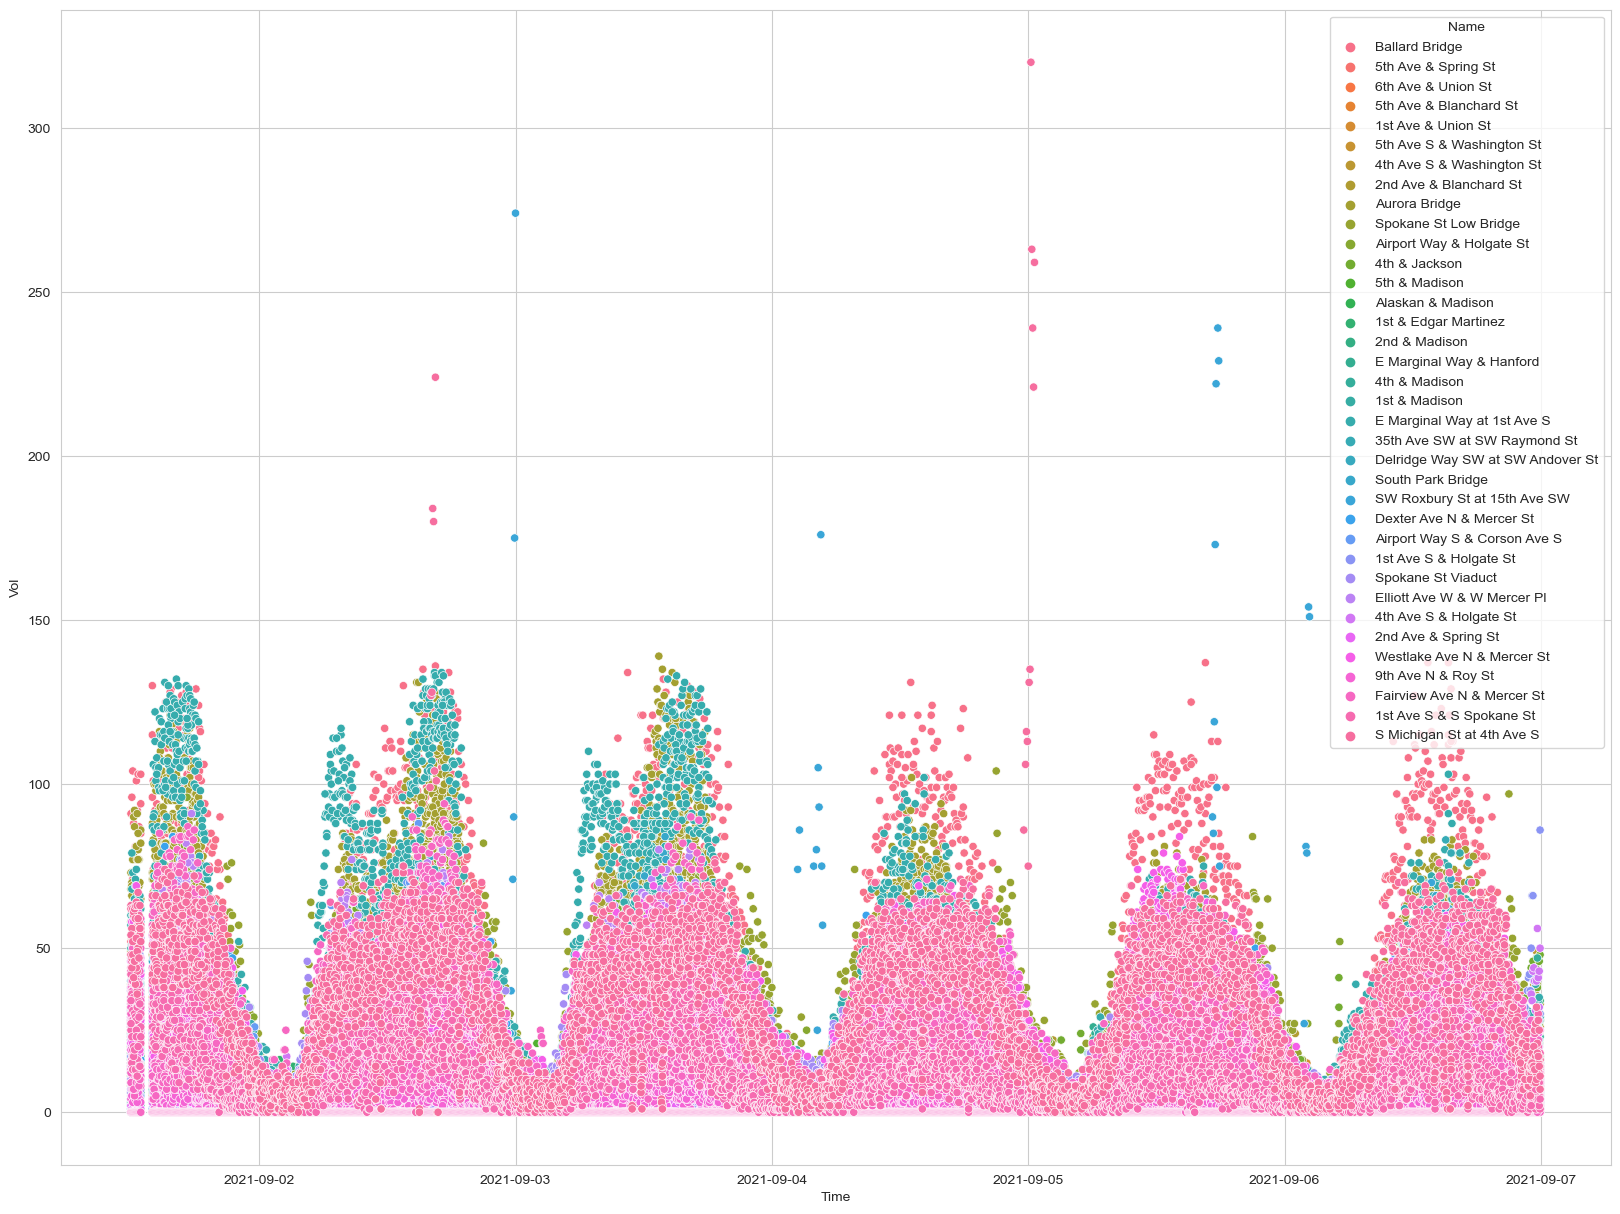

In [ ]:
plt.figure(figsize = (20,15))
sns.scatterplot(data = sept, x = 'Time', y = 'Vol', hue = 'Name')
plt.show()

Arguably want to make a more convincing visual than this to show my point, but I think this at least illustrates that there are relatively similar traffic trends along time across sensors, so I think 

# Data Cleaning

Vehicle Count : Continuous
Weather : Categorical
Light Condition: Categorical
Road Condition: Categorical
Location: Categorical

We start by removing rows of data with null values

In [22]:
crashdf['WEATHER'] = crashdf['WEATHER'].replace('Unknown', np.nan)
crashdf['ROADCOND'] = crashdf['ROADCOND'].replace('Unknown', np.nan)
crashdf['LIGHTCOND'] = crashdf['LIGHTCOND'].replace('Unknown', np.nan)

In [29]:
cleancrash = crashdf[crashdf['WEATHER'].notna()]
cleancrash = cleancrash[cleancrash['ROADCOND'].notna()]
cleancrash = cleancrash[cleancrash['LIGHTCOND'].notna()]
cleancrash = cleancrash[cleancrash['JUNCTIONTYPE'].notna()]
cleancrash = cleancrash[cleancrash['SEVERITYCODE'].notna()] #single instance of NAN after filtering other values

In [30]:
cleancrash.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183454 entries, 0 to 237175
Data columns (total 42 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                180536 non-null  float64
 1   Y                180536 non-null  float64
 2   OBJECTID         183454 non-null  int64  
 3   INCKEY           183454 non-null  int64  
 4   COLDETKEY        183454 non-null  int64  
 5   ADDRTYPE         183307 non-null  object 
 6   COLLISIONTYPE    183437 non-null  object 
 7   EXCEPTRSNCODE    84185 non-null   object 
 8   EXCEPTRSNDESC    854 non-null     object 
 9   FATALITIES       183454 non-null  int64  
 10  INATTENTIONIND   29123 non-null   object 
 11  INCDATE          183454 non-null  object 
 12  INCDTTM          183454 non-null  object 
 13  INJURIES         183454 non-null  int64  
 14  INTKEY           68342 non-null   float64
 15  JUNCTIONTYPE     183454 non-null  object 
 16  LIGHTCOND        183454 non-null  obje

We then prune our dataframe further to only include columns that will be used for modeling

In [59]:
pruned = cleancrash[['WEATHER','ROADCOND','LIGHTCOND','JUNCTIONTYPE','SEVERITYCODE']]

In [60]:
pruned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183454 entries, 0 to 237175
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   WEATHER       183454 non-null  object
 1   ROADCOND      183454 non-null  object
 2   LIGHTCOND     183454 non-null  object
 3   JUNCTIONTYPE  183454 non-null  object
 4   SEVERITYCODE  183454 non-null  object
dtypes: object(5)
memory usage: 12.4+ MB


Now we do our dummy encoding of our discrete variables

In [61]:
pruned.WEATHER.unique()

array(['Clear', 'Overcast', 'Raining', 'Snowing',
       'Sleet/Hail/Freezing Rain', 'Fog/Smog/Smoke', 'Blowing Sand/Dirt',
       'Other', 'Severe Crosswind', 'Partly Cloudy', 'Blowing Snow'],
      dtype=object)

In [62]:
weathercoding = {'Clear': 0,
                'Overcast':1,
                'Raining': 2,
                'Snowing': 3,
                'Sleet/Hail/Freezing Rain': 4,
                'Fog/Smog/Smoke': 5,
                'Blowing Sand/Dirt': 6,
                'Other': 7,
                'Severe Crosswind': 8,
                'Partly Cloudy': 9,
                'Blowing Snow': 10}

In [63]:
veryclean = pruned.replace({'WEATHER': weathercoding})

In [47]:
veryclean.ROADCOND.unique()

array(['Dry', 'Wet', 'Ice', 'Snow/Slush', 'Other', 'Sand/Mud/Dirt',
       'Standing Water', 'Oil'], dtype=object)

In [45]:
roadcondcoding = {'Dry': 0,
                 'Wet': 1,
                 'Ice': 2,
                 'Snow/Slush': 3,
                 'Other': 4,
                 'Sand/Mud/Dirt': 5,
                 'Standing Water': 6,
                 'Oil': 7}

In [64]:
veryclean = veryclean.replace({'ROADCOND': roadcondcoding})

In [50]:
veryclean.LIGHTCOND.unique()

array(['Daylight', 'Dark - Street Lights On', 'Dusk', 'Dawn',
       'Dark - No Street Lights', 'Other', 'Dark - Street Lights Off',
       'Dark - Unknown Lighting'], dtype=object)

In [51]:
lightcondcoding = {'Daylight': 0,
                   'Dark - Street Lights On': 1,
                   'Dusk': 2,
                   'Dawn': 3,
                   'Dark - No Street Lights': 4,
                   'Other': 5,
                   'Dark - Street Lights Off': 6,
                   'Dark - Unknown Lighting': 7}

In [65]:
veryclean = veryclean.replace({'LIGHTCOND': lightcondcoding})

In [55]:
veryclean.JUNCTIONTYPE.unique()

array(['Mid-Block (not related to intersection)',
       'Mid-Block (but intersection related)',
       'At Intersection (intersection related)', 'Driveway Junction',
       'At Intersection (but not related to intersection)',
       'Ramp Junction', 'Unknown'], dtype=object)

In [56]:
junctiontypecoding = {'Mid-Block (not related to intersection)': 0,
                      'Mid-Block (but intersection related)': 1,
                      'At Intersection (intersection related)': 2,
                      'Driveway Junction': 3,
                      'At Intersection (but not related to intersection)': 4,
                      'Ramp Junction': 5,
                      'Unknown': 6}

In [66]:
veryclean = veryclean.replace({'JUNCTIONTYPE': junctiontypecoding})

In [69]:
severitycodecoding = {'0': 0,
                      '1': 1,
                      '2': 2,
                      '2b': 3,
                      '3': 4}

In [73]:
veryclean = veryclean.replace({'SEVERITYCODE': severitycodecoding})

In [75]:
veryclean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183454 entries, 0 to 237175
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   WEATHER       183454 non-null  int64
 1   ROADCOND      183454 non-null  int64
 2   LIGHTCOND     183454 non-null  int64
 3   JUNCTIONTYPE  183454 non-null  int64
 4   SEVERITYCODE  183454 non-null  int64
dtypes: int64(5)
memory usage: 12.4 MB


# Modeling

In [76]:
from sklearn.model_selection import train_test_split